In [2]:
from skimage.feature import hog
from skimage import color, exposure
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.sklearn
from sklearn.decomposition import PCA


In [3]:
mlflow.set_tracking_uri(uri=" http://127.0.0.1:5000")

In [4]:
mlflow.set_experiment("SVM_mdl_cifar")

<Experiment: artifact_location='mlflow-artifacts:/833763844475826793', creation_time=1733880759591, experiment_id='833763844475826793', last_update_time=1733880759591, lifecycle_stage='active', name='SVM_mdl_cifar', tags={}>

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
subset_size_train = 5000
subset_size_test = 2000
indices_train = np.random.choice(x_train.shape[0], subset_size_train, replace=False)
indices_test = np.random.choice(x_test.shape[0], subset_size_test, replace=False)
x_train_subset = x_train[indices_train]
y_train_subset = y_train[indices_train]
x_test_subset = x_test[indices_test]
y_test_subset = y_test[indices_test]
# Utiliser seulement les 8000 premiers exemples pour l'entraînement
x_train_subset = y_train.ravel()  # Convertir y_train en un vecteur 1D
y_test_subset = y_test.ravel()  # Convertir y_test en un vecteur 1D

# Fonction pour extraire les caractéristiques HOG des images
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convertir l'image en niveaux de gris et extraire les caractéristiques HOG
        gray_image = color.rgb2gray(image)
        fd, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Extraction des caractéristiques HOG pour les ensembles d'entraînement et de test
x_train_hog = extract_hog_features(x_train_subset)
x_test_hog = extract_hog_features(x_test_subset)

# Définir les combinaisons de paramètres pour les expérimentations avec gamma
experiment_params = [
    {"svm__kernel": "linear", "svm__C": 1.0},
    {"svm__kernel": "rbf", "svm__C": 10},
]


# Créer un pipeline de prétraitement et de classification SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Normalisation des données
    ('pca', PCA(n_components=100)), # Réduction de la dimensionnalité
    ('svm', SVC())  # Classificateur SVM
])

# Pour chaque combinaison de paramètres, démarrer un MLflow run
for params in experiment_params:
    with mlflow.start_run():

        # Log des paramètres du modèle
        mlflow.log_param("kernel", params["svm__kernel"])
        mlflow.log_param("C", params["svm__C"])
        mlflow.log_param("gamma", params["svm__gamma"])

        # Initialiser et entraîner le modèle avec les paramètres actuels
        pipeline.set_params(svm__kernel=params["svm__kernel"], svm__C=params["svm__C"], svm__gamma=params["svm__gamma"])
        pipeline.fit(x_train_hog, y_train_subset)
        
        # Prédictions et évaluation du modèle
        y_pred = pipeline.predict(x_test_hog)
        
        accuracy = accuracy_score(y_test_subset, y_pred)
        precision = precision_score(y_test_subset, y_pred, average='weighted')
        recall = recall_score(y_test_subset, y_pred, average='weighted')
        f1 = f1_score(y_test_subset, y_pred, average='weighted')
        
        # Log des métriques
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log du modèle entraîné
        mlflow.sklearn.log_model(pipeline, "svm_cifar_hog_model")
        
        print(f"Logged metrics and model with kernel={params['svm__kernel']}, C={params['svm__C']}, gamma={params['svm__gamma']}")


2024/12/11 05:39:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/11 05:39:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-deer-304 at:  http://127.0.0.1:5000/#/experiments/833763844475826793/runs/d4f4c21ec47a4f09ac9b45d2e2d8e981.
2024/12/11 05:39:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at:  http://127.0.0.1:5000/#/experiments/833763844475826793.


Logged metrics and model with kernel=linear, C=1.0, gamma=0.01


2024/12/11 05:54:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/11 05:54:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-zebra-938 at:  http://127.0.0.1:5000/#/experiments/833763844475826793/runs/fc1e5df5a85f4b7da69d190b81572b89.
2024/12/11 05:54:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at:  http://127.0.0.1:5000/#/experiments/833763844475826793.


Logged metrics and model with kernel=rbf, C=10, gamma=0.01


2024/12/11 06:08:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/11 06:08:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-ram-291 at:  http://127.0.0.1:5000/#/experiments/833763844475826793/runs/8735e86376b7458a8fa5ede569c53626.
2024/12/11 06:08:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at:  http://127.0.0.1:5000/#/experiments/833763844475826793.


Logged metrics and model with kernel=rbf, C=100, gamma=0.01


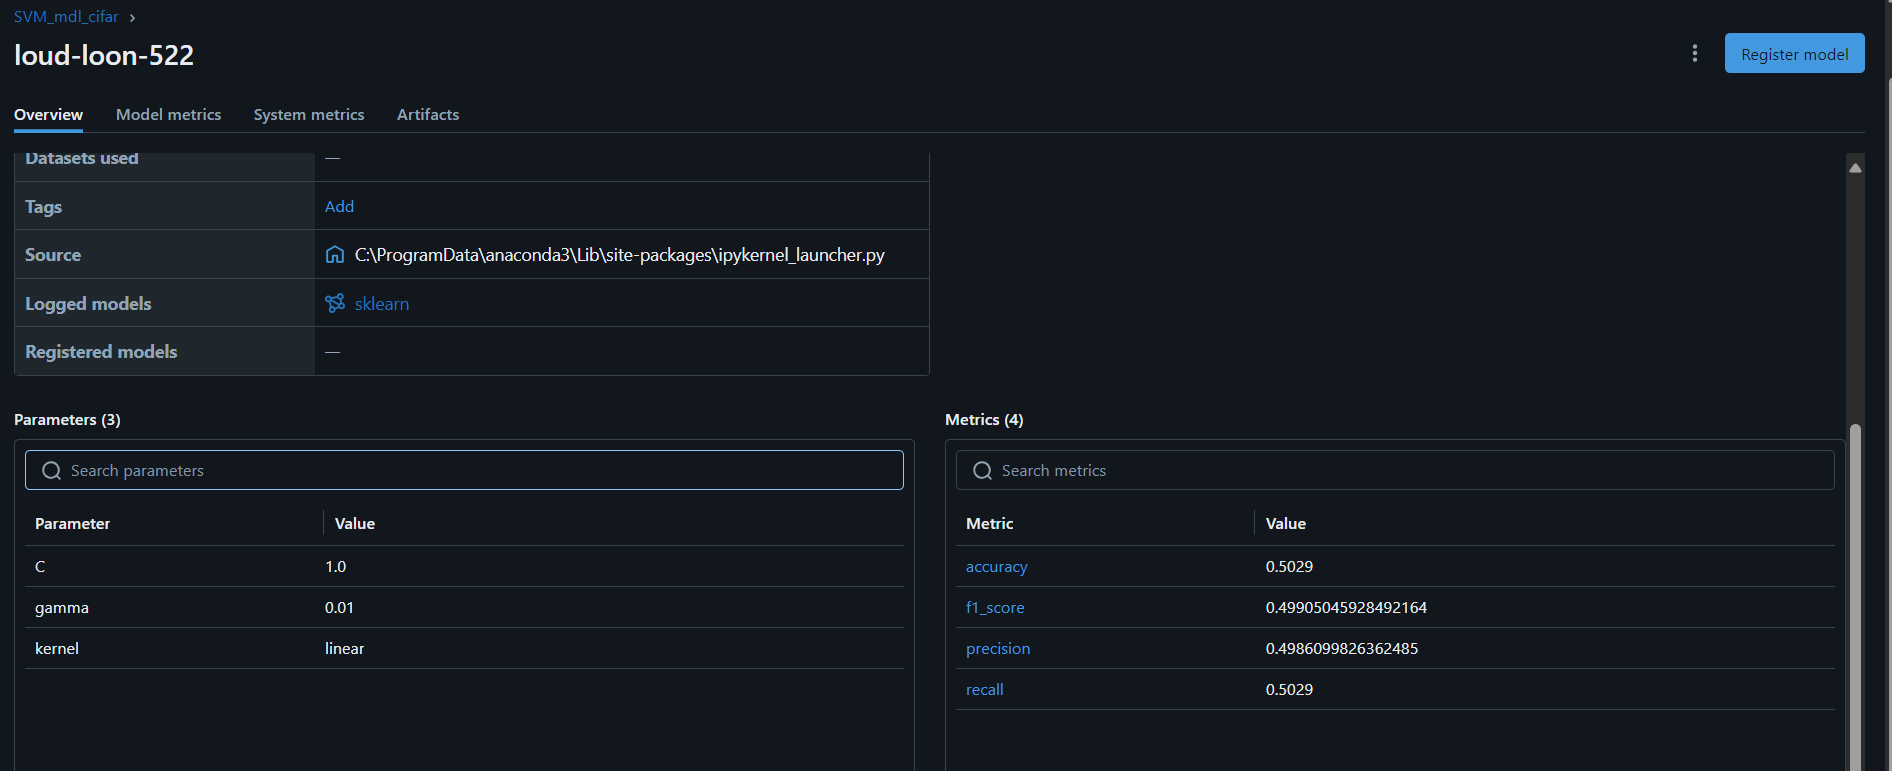

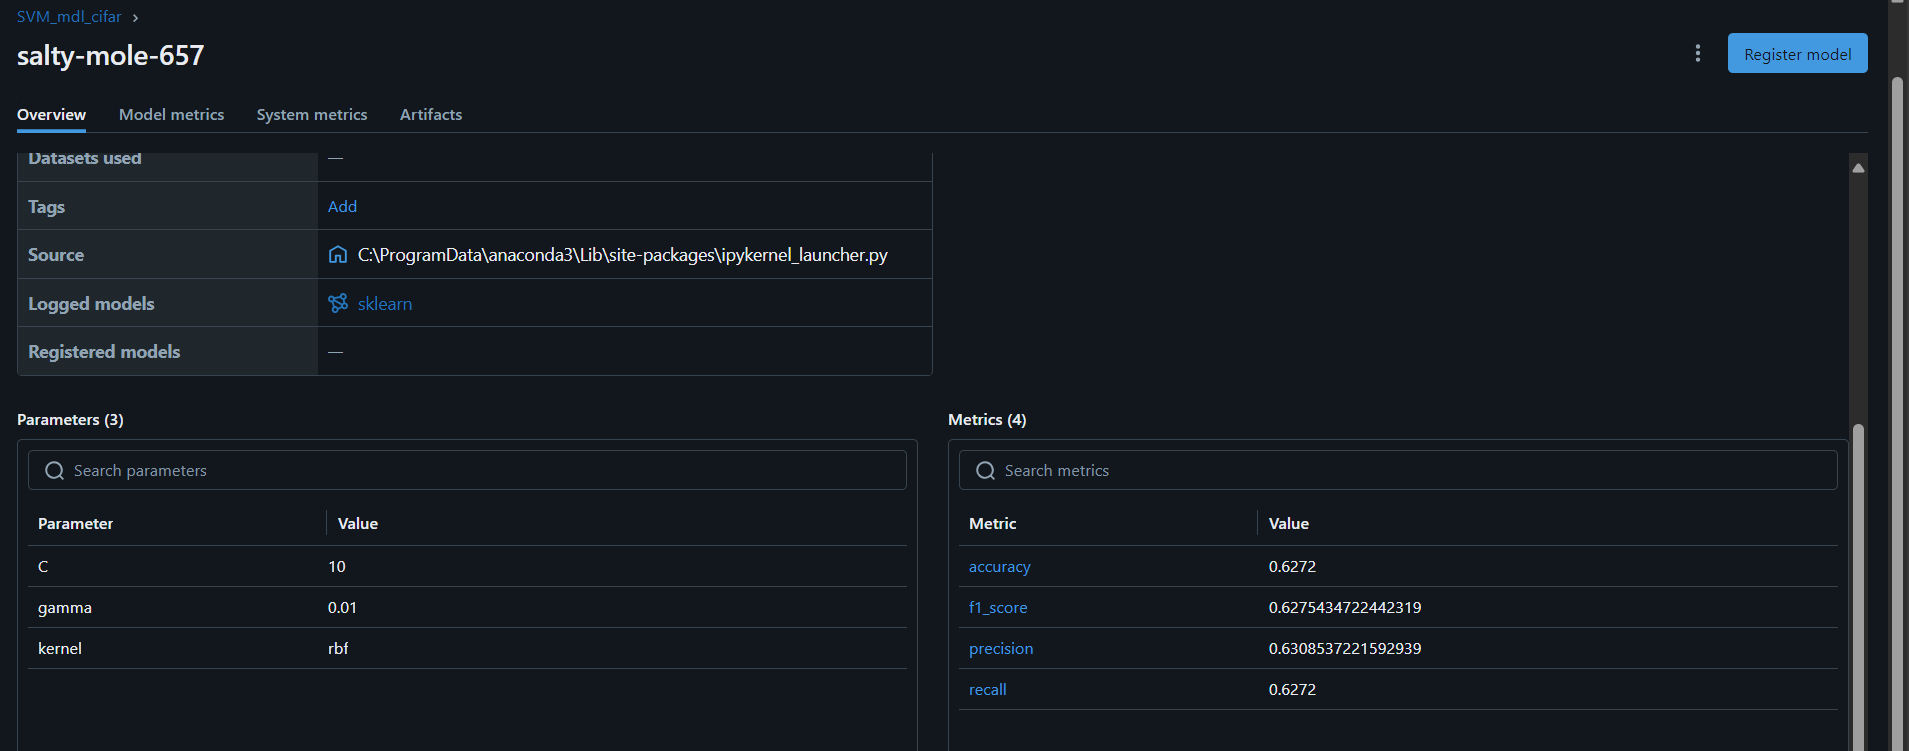

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Utiliser les étiquettes réelles et prédites
y_true = y_test  # Étiquettes réelles
y_pred = pipeline.predict(x_test_hog)  # Étiquettes prédites

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualiser la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Labels Prédits")
plt.ylabel("Labels Réels")
plt.title("Matrice de Confusion")

# Enregistrer le graphique de la matrice de confusion
conf_matrix_path = "confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.close()

# Utiliser l'ID de run spécifié pour enregistrer l'artifact dans MLflow
with mlflow.start_run(run_id="3eacb8baafd048b587de1a570cf6d34c"):
    mlflow.log_artifact(conf_matrix_path)

# Optionnel : supprimer le fichier de la matrice de confusion après enregistrement
import os
os.remove(conf_matrix_path)

print("La matrice de confusion a été enregistrée avec succès dans MLflow.")


2024/12/11 04:02:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-rat-677 at:  http://127.0.0.1:5000/#/experiments/833763844475826793/runs/3eacb8baafd048b587de1a570cf6d34c.
2024/12/11 04:02:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at:  http://127.0.0.1:5000/#/experiments/833763844475826793.


La matrice de confusion a été enregistrée avec succès dans MLflow.


In [7]:
registered_model_name = "svm_ML_B"
model_uri = f"runs:/f13a4c5ee92e41c8be026759ea5dbc9f/svm_ML_B"

mlflow.register_model(model_uri=model_uri, name=registered_model_name)
mlflow.log_artifact('C:/Users/samik/mlruns/833763844475826793/f13a4c5ee92e41c8be026759ea5dbc9f/artifacts', 'artifacts')
print(f"Model registered")

Successfully registered model 'svm_ML_B'.
2024/12/11 09:09:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: svm_ML_B, version 1


Model registered


Created version '1' of model 'svm_ML_B'.


SHAP AND LIME

In [8]:
import numpy as np

def decision_to_proba(decision_scores):
    """
    Convert decision_function outputs to pseudo-probabilities using softmax.
    """
    # Appliquer softmax pour chaque exemple
    exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
    probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probabilities


In [9]:
def predict_fn(data):
    decision_scores = pipeline.decision_function(data)
    return decision_to_proba(decision_scores)


In [11]:
# Aplatir les données d'entraînement pour LIME
x_train_flat = x_train.reshape(len(x_train), -1)  # Transforme (n_samples, 32, 32, 3) en (n_samples, 3072)
x_test_flat = x_test.reshape(len(x_test), -1)    # Même transformation pour les données de test


In [20]:
import numpy as np

def decision_to_proba(decision_scores):
    """
    Convertir les scores de décision en pseudo-probabilités avec softmax.
    """
    exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
    probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probabilities

def predict_fn(data):
    """
    Fonction de prédiction adaptée pour LIME.
    Elle prend des données en entrée, les passe à travers le pipeline (transformations),
    et retourne des probabilités prédictives.
    """
    # S'assurer que les données sont au format attendu par le pipeline
    if data.ndim == 1:  # Si un seul exemple, ajouter une dimension
        data = data.reshape(1, -1)
    
    # Appliquer les transformations initiales (StandardScaler + PCA)
    transformed_data = pipeline[:-1].transform(data)
    
    # Obtenir les scores de décision de la dernière étape (SVM)
    decision_scores = pipeline.named_steps['svm'].decision_function(transformed_data)
    
    # Convertir les scores de décision en pseudo-probabilités
    return decision_to_proba(decision_scores)



In [21]:
# Aplatir les données pour qu'elles aient une forme compatible avec LIME
x_train_flat = x_train.reshape(len(x_train), -1)  # (n_samples, 3072)
x_test_flat = x_test.reshape(len(x_test), -1)    # (n_samples, 3072)


In [22]:
from lime.lime_tabular import LimeTabularExplainer

# Initialisation de LIME avec les données d'entraînement aplaties
explainer = LimeTabularExplainer(
    training_data=x_train_flat,
    feature_names=[f'pixel_{i}' for i in range(x_train_flat.shape[1])],
    class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    mode='classification'
)


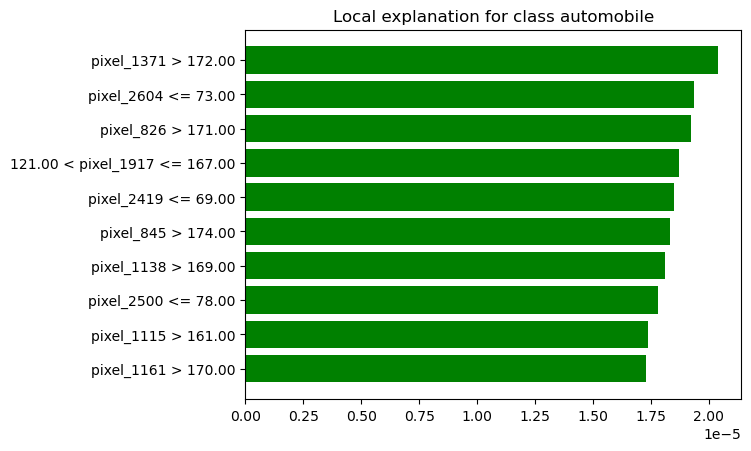

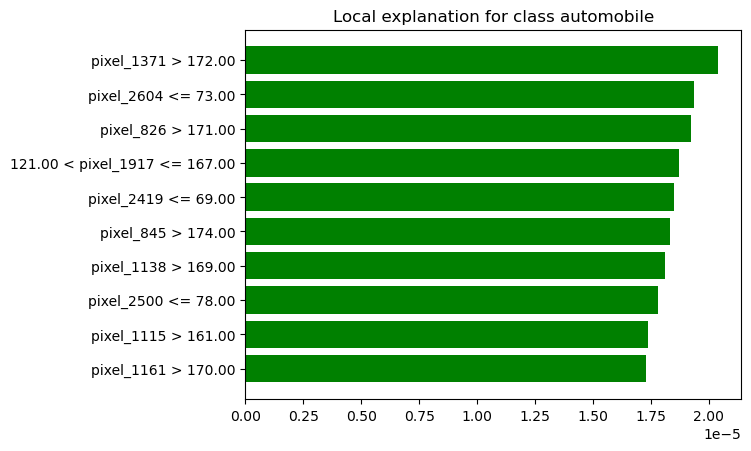

In [30]:
# Aplatir les données CIFAR-10
x_train_flat = x_train.reshape(len(x_train), -1)  # (n_samples, 3072)
x_test_flat = x_test.reshape(len(x_test), -1)

# Réajuster le pipeline avec les données aplaties
pipeline.fit(x_train_flat, y_train)

# Fonction de conversion des scores de décision en pseudo-probabilités
def decision_to_proba(decision_scores):
    """
    Convertit les scores de décision en pseudo-probabilités à l'aide de softmax.
    """
    # Appliquer softmax pour chaque exemple
    exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
    probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probabilities

# Fonction de prédiction pour LIME
def predict_fn(data):
    """
    Fonction de prédiction pour LIME.
    Applique les transformations du pipeline (scaler + pca) puis obtient les scores de décision.
    """
    # Appliquer les étapes du pipeline
    decision_scores = pipeline.decision_function(data)  # Obtenir les scores de décision
    return decision_to_proba(decision_scores)  # Convertir en pseudo-probabilités

# Créer un explainer LIME avec les données aplaties
explainer = LimeTabularExplainer(
    training_data=x_train_flat,   # Données d'entraînement aplaties
    feature_names=[f'pixel_{i}' for i in range(x_train_flat.shape[1])],
    class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    mode='classification'
)

# Indice de l'exemple à expliquer
i = 0

# Générer une explication
data_row=x_test_flat[i],  # Exemple à expliquer (données aplaties)
predict_fn=predict_fn,    # Fonction de prédiction
num_features=10           # Nombre de caractéristiques explicatives


# Afficher l'explication
explanation.as_pyplot_figure()